# Embryoid Body Dataset Gene Plots (Figure 8 in TrajectoryNet paper)

This shows how to use backwards trajectories computed through our GP_IPFP procedure in the gene space.

These trajectories take points in the final timepoint and integrate them backwards in N evenly spaced timepoints to the starting timepoint. This means we now a have data that represents the inferred "paths" taken through the embedding space to the output. The case where we have an invertible embedding such as PCA, this allows us to get approximate trajectories in gene space.

In this case we performed GP_IPFP on 5d PCA on the EB data. We then can compute the trajectories in Gene space.


## Requirements

Install The following packages if not already set up:

In [1]:
# Uncomment if Needed
# !pip install --user magic-impute
# !pip install --user phate
# !pip install --user scprep

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from TrajectoryNet.dataset import EBData

from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn.utils import plot_trajectories_2

import torch

from celluloid import Camera
from IPython.display import HTML
import math

In [3]:
# Loading the dataset from the TrajectoryNet repo file eb_velocity_v5.npz, which we added to our repo

ds = EBData('pcs', max_dim=5)

In [4]:
ds.get_data().shape

(16819, 5)

<AxesSubplot:>

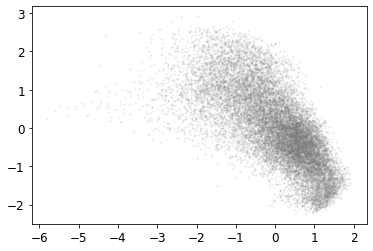

In [5]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(ds.get_data(), c='Gray', alpha=0.1, ax=ax)

### Extracting Start and Endpoint Frames

Extracting the frames to fit GP_IPFP on.

In [6]:
frame_0_start, frame_0_end = np.where(ds.labels == 0)[0][0], np.where(ds.labels == 0)[0][-1]
frame_4_start, frame_4_end = np.where(ds.labels == 4)[0][0], np.where(ds.labels == 4)[0][-1]

### Fitting GP_IPFP on GB_Data

Here we setup and fit our IPFP procedure on the EB data. Note when using the server one can just comment these cells and instead load in the trajectories to be analysed directly into the variable `zs` . If you are loading trajectories from the cerver CTRL-f DATA HERE now.

In [15]:
X_0_f = ds.get_data()[frame_0_start:frame_0_end+1]
X_1_f = ds.get_data()[frame_4_start:]

# Subsample terminals
perm_0 = np.random.permutation(np.arange(len(X_0_f)))
perm_1 = np.random.permutation(np.arange(len(X_1_f)))
k = 500

# X_0 = torch.tensor(X_0_f[perm_0][:])
# X_1 = torch.tensor(X_1_f[perm_1][:])
X_0 = torch.tensor(X_0_f)
X_1 = torch.tensor(X_1_f)

In [16]:
X_1_f.shape

(3332, 5)

In [59]:
# SDE Solver config
sigma = 0.5
dt = 0.05
N = int(math.ceil(1.0/dt))
N = 21
dt = 1/N
# IPFP init config
prior_X_0 = torch.cat((X_0, X_1))

# Inducing points approximation config
data_inducing_points = 150
time_inducing_points = N # No time reduction
num_data_points_prior = 50
num_time_points_prior = N

# sparse enables the nystrom method which is just a low rank approximation of the kernel matrix using
# random subsampling, should not affect interpretability much, ive tested it in all our experiments
# works surprisingly well
result = MLE_IPFP(
    X_0,X_1,N=N,sigma=sigma, iteration=10, sparse=True, 
    num_data_points=data_inducing_points, num_time_points=time_inducing_points, prior_X_0=prior_X_0,
    num_data_points_prior=num_data_points_prior, num_time_points_prior=num_time_points_prior
)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]

 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:46<00:07,  2.55s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:54<00:00,  2.58s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:55<00:00,  2.66s/it]

 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:39<00:08,  2.24s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:59<00:00,  2.84s/it]

 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:42<00:15,  2.66s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:57<00:00,  2.75s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:58<00:00,  2.77s/it]

 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:31<00:15,  2.20s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:00<00:00,  2.86s/it]

 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:37<00:26,  2.97s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:02<00:00,  2.95s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:56<00:00,  2.70s/it]

 52%|██████████████████████████████████████████▉                                       | 11/21 [00:23<00:20,  2.09s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:56<00:00,  2.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:58<00:00,  2.77s/it]


<AxesSubplot:>

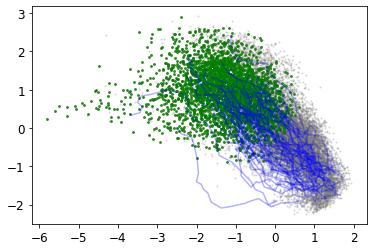

In [61]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(ds.get_data(), c='Gray', alpha=0.1, ax=ax)
for i in range(50):
    plt.plot(result[-1][-1][i,:,0].cpu().detach().numpy(), result[-1][-1][i,:,1].cpu().detach().numpy(), alpha=0.3, color="blue")
scprep.plot.scatter2d(ds.get_data(), c='Gray', alpha=0.1, ax=ax)
scprep.plot.scatter2d(X_1_f, c='Red', alpha=0.1, ax=ax)
scprep.plot.scatter2d(X_1.detach().cpu().numpy(), c='Green', alpha=0.7, ax=ax)

<AxesSubplot:>

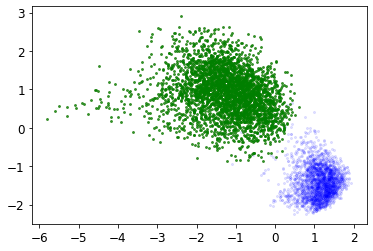

In [20]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(X_0_f, c='Blue', alpha=0.1, ax=ax)
scprep.plot.scatter2d(X_1_f, c='Red', alpha=0.1, ax=ax)
scprep.plot.scatter2d(X_1.detach().cpu().numpy(), c='Green', alpha=0.7, ax=ax)

### Load Trajectory Data HERE !

If not using the GP_IPFP fitting above just load the trajectory data in the cell below (i.e. uncomment the first line in the next cell).

In [62]:
# results = pd.read_pickle("../assets/result_dump/result_final.pkl")
zs = result[-1][-1][:,:,:-1] # backward tracjectories, remove time component

In [63]:
import pandas as pd

# Use EmbryoidBodyPHATE.ipynb to generate these

EBT_counts = pd.read_pickle('../data/preprocessed_ebt_counts.pkl')
sample_labels = pd.read_pickle('../data/preprocessed_ebt_counts_labels.pkl')

In [64]:
import phate
phate_operator = phate.PHATE(n_jobs=-2, random_state=42)
Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 21.76 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.74 seconds.
    Calculating affinities...
    Calculated affinities in 1.13 seconds.
  Calculated graph and diffusion operator in 31.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.49 seconds.
    Calculating KMeans...
    Calculated KMeans in 18.31 seconds.
  Calculated landmark operator in 21.00 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.95 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.97 seconds.
Calculated PHATE in 62.25 seconds.


In [65]:
import sklearn.preprocessing
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(phate_operator.graph.data_nu)

StandardScaler()

In [66]:
#  The Trajectory net people transposed data and time, aligning with the rest of their code here

zs = zs.permute(1,0, 2)

zs.shape

torch.Size([22, 3332, 5])

In [67]:
# Rescaling according to PHATE 
zss = zs * scaler.scale_[:5] + scaler.mean_[:5]

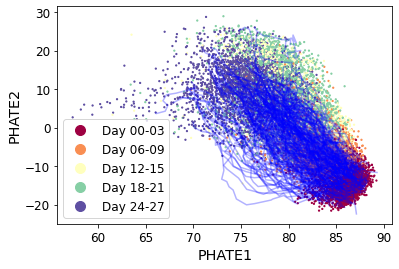

In [68]:
# Plotting trajectories in PHATE rescaling

fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(phate_operator.graph.data_nu, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=True, label_prefix="PHATE", ax=ax)

for i in range(200):
    ax.plot(zss[:,i,0], zss[:,i,1], alpha=0.3, color="blue")

### Phate Plot

Here we plot all the genes in the reduced 2D PHATE space (Not sure why but its part of figure 8)

In [69]:
pcs = phate_operator.graph.data_pca.components_[:5]

<AxesSubplot:>

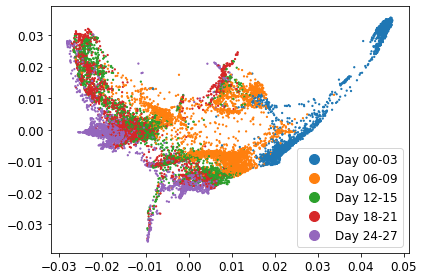

In [70]:
scprep.plot.scatter2d(Y_phate, sample_labels)

### Exracting Interesting Genes

In the next few cells the specific (interesting) genes from figure 8 are extracted. These will be visualised later on. These cells are all direct copy and pastes from the TrajectoryNet repository (EB_Dataset notebook).

In [71]:
end_genes = ['PDGFRA ', 'HAND1', 'SOX17', 'ONECUT2', ]
end_points = ['Muscle', 'Cardiac', 'Endothelial', 'Neuronal',]
#end_genes = [ 'HAND1', 'ONECUT2',]
#end_points = ['Cardiac', 'Neuronal', ]

colors = dict(zip(*[end_genes, [plt.get_cmap('tab10')(i+1) for i in range(len(end_genes))]]))
print(colors)
other_genes = ['GATA6 ', 'SATB1', 'T ', 'EOMES', 'NANOG', 'TNNT2', 'DLX1', 'TBX18', 'MAP2 ']
genes_of_interest = [*other_genes, *end_genes]
genes_of_interest_end = scprep.select.get_gene_set(EBT_counts, starts_with=end_genes)
genes_of_interest_other = scprep.select.get_gene_set(EBT_counts, starts_with=other_genes)
genes_of_interest_full = scprep.select.get_gene_set(EBT_counts, starts_with=genes_of_interest)
print(genes_of_interest_full.shape)
genes_mask = EBT_counts.columns.isin(genes_of_interest_full)

genes = EBT_counts.columns[genes_mask]

inverse = np.dot(zss, phate_operator.graph.data_pca.components_[:5, genes_mask])
end_gene_indexes = [(np.where(genes_of_interest_full == gene)[0][0]) for gene in genes_of_interest_end]

{'PDGFRA ': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'HAND1': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'SOX17': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'ONECUT2': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)}
(13,)


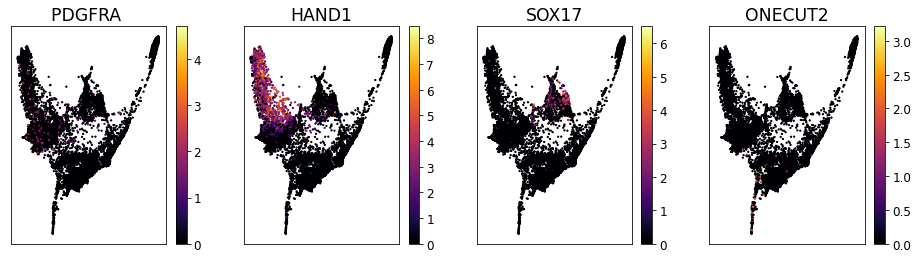

In [72]:
fig, ax = plt.subplots(1,len(end_genes), figsize=(4*len(end_genes),4))
ax = ax.flatten()
for i in range(len(end_genes)):
    scprep.plot.scatter2d(Y_phate, 
                          c=EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with=end_genes[i])], 
                          ax=ax[i],
                          title=end_genes[i],
                          ticks=[],
                         )

In [73]:

import magic

m_op = magic.MAGIC()
m_op.graph = phate_operator.graph
X_magic = m_op.transform(EBT_counts, genes=genes_of_interest_full)

C:\Users\vargf\AppData\Roaming\Python\Python38\site-packages\magic\magic.py:592: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculating imputation...
Calculated imputation in 0.02 seconds.


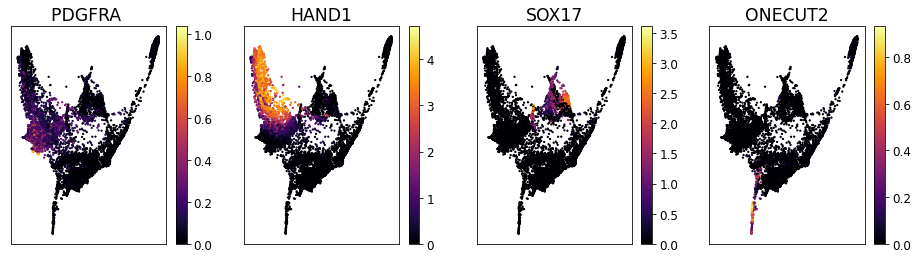

In [74]:

fig, ax = plt.subplots(1,len(end_genes), figsize=(4*len(end_genes),4))
ax = ax.flatten()
for i in range(len(end_genes)):
    scprep.plot.scatter2d(Y_phate, 
                          c=X_magic[scprep.select.get_gene_set(EBT_counts, starts_with=end_genes[i])], 
                          ax=ax[i],
                          title=end_genes[i],
                          ticks=[],
                         )

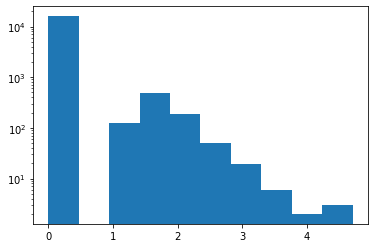

In [75]:
plt.hist(np.array(EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with='PDGFRA ')]).flatten())
#plt.xscale('log')
plt.yscale('log')


In [76]:
np.sum(np.array(EBT_counts[scprep.select.get_gene_set(EBT_counts, starts_with='PDGFRA ')]) > 0)


879

In [77]:
np.unique(sample_labels, return_counts=True)

(array(['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27'],
       dtype=object),
 array([2381, 4165, 3278, 3665, 3332], dtype=int64))

In [78]:
EBT_5 = EBT_counts[sample_labels == 'Day 24-27']
EBT_5.shape

(3332, 17845)

In [79]:
for gene in end_genes:
    print(gene, np.sum(np.array(EBT_5[scprep.select.get_gene_set(EBT_counts, starts_with=gene)]) > 0))

PDGFRA  324
HAND1 218
SOX17 12
ONECUT2 10


In [80]:
masks = {}
top_idxs = {}
for gene in end_genes:
    top_idx = np.array(EBT_5[scprep.select.get_gene_set(EBT_counts, starts_with=gene)]).flatten().argsort()[-9:]
    top_mask = np.array(pd.Series(range(3332)).isin(top_idx))
    masks[gene] = top_mask
    top_idxs[gene] = top_idx
    print(gene, top_idx)

PDGFRA  [1896 2642  488  748  664  697 1419  300  432]
HAND1 [1959 3195  936 2133  375  668  501 2484 1476]
SOX17 [2053 2595 2664 1988 2353 1129 2823  738  532]
ONECUT2 [2920  555 2283  718 1275 2125 1838 2129 2277]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

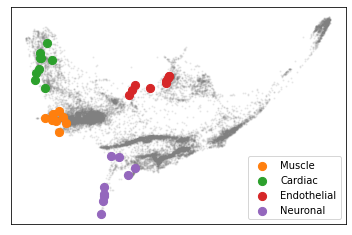

In [81]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(Y_phate, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'][masks[gene]], 
                          ax=ax, c = colors[gene], label=end_points[i], ticks=[])
    
plt.legend()

In [82]:
zss.shape

torch.Size([22, 3332, 5])

In [83]:

# reshaped 21 from 100 not sure if that was a good idea ? (N is now 100 again)
paths = phate_operator.transform(np.reshape(np.concatenate([zss, np.zeros((N+1, 3332, 95))], axis=-1), (-1, 100)))

Calculating KNN search...


C:\Users\vargf\anaconda3\lib\site-packages\phate\phate.py:877: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 30.32 seconds.
Calculating affinities...
Calculated affinities in 12.93 seconds.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

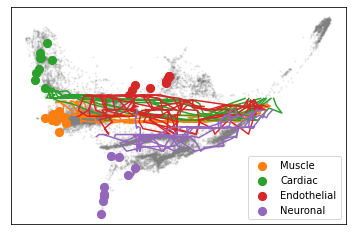

In [84]:
fig, ax = plt.subplots(1,1)
scprep.plot.scatter2d(Y_phate, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    scprep.plot.scatter2d(Y_phate[sample_labels=='Day 24-27'][masks[gene]], 
                          ax=ax, c = colors[gene], label=end_points[i], ticks=[])
    
plt.legend()

for i, gene in enumerate(end_genes) :
    pp = paths.reshape(N+1, -1, 2)[:, masks[gene]]
    for p in range(pp.shape[1]):
        plt.plot(pp[:, p, 0], pp[:, i, 1], c=colors[gene])

### Visualising Latent Paths for  Interesting Genes

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

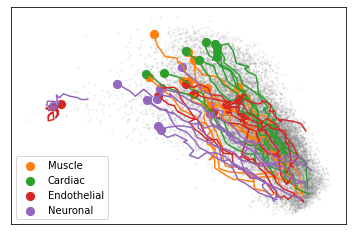

In [85]:
dims = (0,1)
#import matplotlib.
dn = phate_operator.graph.data_nu[:, dims]


fig, ax = plt.subplots(1,1)#, figsize=(20,20))
scprep.plot.scatter2d(dn, c='Gray', alpha=0.1, ax=ax)
#scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'], ax=ax)
for i, gene in enumerate(end_genes):
    #print(colors[gene])
    scprep.plot.scatter2d(dn[sample_labels=='Day 24-27'][masks[gene]], ax=ax, 
                          label='%s' % (end_points[i]), c=colors[gene], ticks=[])

for gene in end_genes:
    for g in top_idxs[gene]:
        ax.plot(zss[:,g,dims[0]], zss[:,g,dims[1]], c=colors[gene])
plt.legend()

## Paths back to the Data space ?

I think these are visuals on the paths back in the dataspace where the dimensions are identifiable known things.

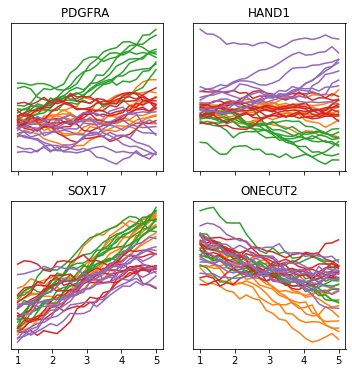

In [86]:

#fig, ax = plt.subplots(3,5, figsize=(20,12))
fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True)
ax = ax.flatten()

for i, gene in enumerate(end_genes):
    for j, eg in enumerate(end_genes):
        for g in top_idxs[eg]:
            #print(genes_of_interest_full[end_gene_indexes[i]])
            ax[i].plot(np.linspace(1,5,N+1)[::-1], inverse[:,g,end_gene_indexes[i]], c=colors[eg])
            ax[i].set_title(gene)
            ax[i].set_yticks([])
            ax[i].set_xticks(range(1,6))
        #ax[i].set_xticks()

In [50]:
print(genes)

Index(['DLX1 (ENSG00000144355)', 'EOMES (ENSG00000163508)',
       'GATA6 (ENSG00000141448)', 'HAND1 (ENSG00000113196)',
       'MAP2 (ENSG00000078018)', 'NANOG (ENSG00000111704)',
       'ONECUT2 (ENSG00000119547)', 'PDGFRA (ENSG00000134853)',
       'SATB1 (ENSG00000182568)', 'SOX17 (ENSG00000164736)',
       'T (ENSG00000164458)', 'TBX18 (ENSG00000112837)',
       'TNNT2 (ENSG00000118194)'],
      dtype='object')
